# Проект 3. Дашборд конверсий

In [417]:
import pandas as pd
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates 
from matplotlib.dates import (MO, WeekdayLocator)
from dotenv import load_dotenv

In [354]:
load_dotenv()  # загружаются переменные из файла

DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')


In [462]:
def create_visits():
    # Подготавливаем датасет с визитами
    visits = pd.DataFrame(requests.get(f'{API_URL}/visits', params={'begin': DATE_BEGIN, 'end': DATE_END}).json())
    visits['datetime'] = pd.to_datetime(visits['datetime'])
    visits['date'] = pd.to_datetime(visits['datetime']).dt.date
    visits = visits[~visits['user_agent'].str.contains('bot')] # Чистим датафрейм с посещениями от ботов
    last_visits = visits.groupby(['visit_id'], as_index=False).datetime.agg('max') # Оставляем только последние визиты по Visit_id
    last_visits = last_visits.merge(visits, left_on=['visit_id','datetime'], right_on=['visit_id','datetime'],how='left')
    visits_gr = last_visits.groupby(['date', 'platform'],as_index=False)['visit_id']\
            .nunique().rename(columns={'visit_id':'visits'}) # Создаем сгруппированный датафрейм по дате и платформе
    visits_gr['date'] = pd.to_datetime(visits_gr['date'])
    return visits_gr

In [464]:
def create_registrations():
    # Подготавливаем датасет с регистрациями
    regs = pd.DataFrame(requests.get(f'{API_URL}/registrations', params={'begin': DATE_BEGIN, 'end': DATE_END}).json())
    regs['datetime'] = pd.to_datetime(regs['datetime'])
    regs['date'] = pd.to_datetime(regs['datetime']).dt.date
    regs_gr = regs.groupby(['date', 'platform'],as_index=False)['user_id']\
            .nunique().rename(columns={'user_id':'registrations'}) # Создаем сгруппированный датафрейм по дате и платформе
    regs_gr['date'] = pd.to_datetime(regs_gr['date'])
    return regs_gr

In [454]:
def create_merged_df(visits_gr, regs_gr):
    # Создаем объединенный датафрейм по дате и платформе и находим конверсию по дате в %
    merged_df = pd.merge(visits_gr, regs_gr,
                     how='outer',
                     left_on=['date', 'platform'],
                     right_on=['date', 'platform']
                    )
    merged_df['conversion']=merged_df['registrations']*100/merged_df['visits']
    merged_df.to_json('./conversion.json')
    return merged_df

In [456]:
def create_ads():
    # Подготавливаем датасет с рекламой
    ads = pd.read_csv('ads.csv')
    ads['date'] = pd.to_datetime(pd.to_datetime(ads['date']).dt.date)
    return ads

In [458]:
def create_merged_df_with_ads(merged_df, ads_df):
    # Создаем объединенный датафрейм по дате, визитам, регистрациям и затратам на рекламу
    result = merged_df.groupby(['date'], as_index=False)\
            .agg({'visits':'sum', 'registrations':'sum'})\
            .merge(ads_df, how='left', left_on='date', right_on='date')
    result.to_json('./ads.json')
    return result

In [466]:
visits_gr = create_visits()

In [468]:
regs_gr = create_registrations()

In [470]:
merged_df = create_merged_df(visits_gr, regs_gr)

In [472]:
ads = create_ads()

In [474]:
result = create_merged_df_with_ads(merged_df, ads)

## Визуальный анализ данных

**Распределение количества визитов по дням**

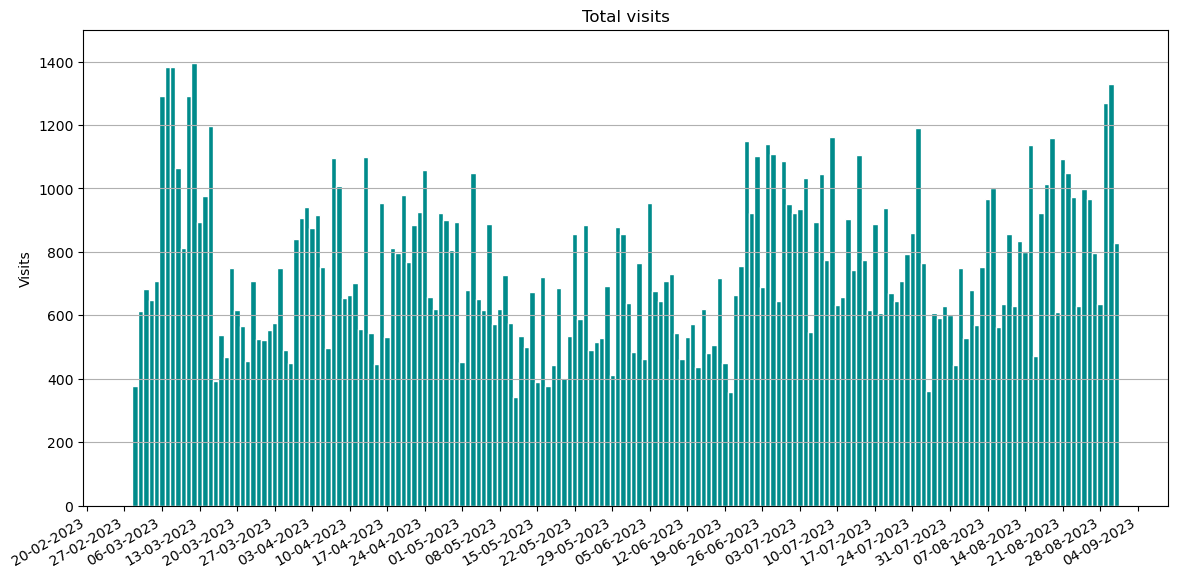

In [415]:
from matplotlib.dates import (MO, WeekdayLocator)
df = merged_df.groupby(['date'],as_index=False).visits.sum()
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

# Изменим локатор, используемый по умолчанию
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# Установим шрифт и поворот для меток даты
plt.gcf().autofmt_xdate()

# Отобразим данные
ax.bar(df['date'], df['visits'], width=1, color='darkcyan', edgecolor='white')

ax.set(ylabel='Visits', title='Total visits', ylim=(0, 1500))

ax.grid(axis='y')
plt.savefig(f'./charts/Total_visits.png')
plt.show()

**Итоговые визиты с разбивкой по платформам**


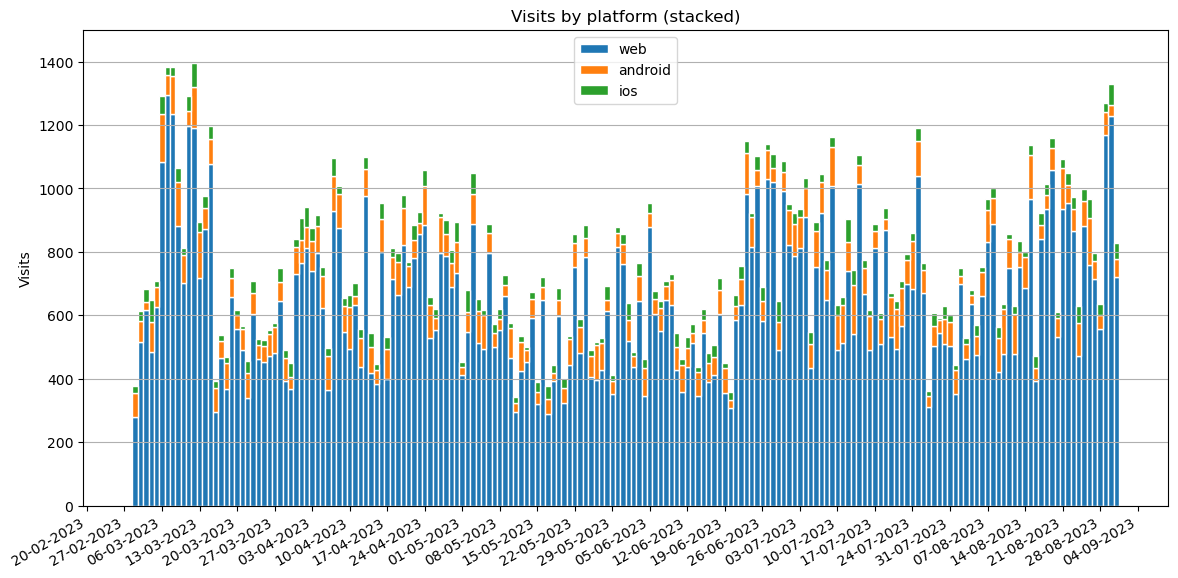

In [421]:
# Преобразуем данные в сводную таблицу, в которой названия платформ будут расположены в колонках, а даты — в строках.
df = merged_df \
    .groupby(['date', 'platform'], as_index=False) \
    .agg({'visits': 'sum'}) \
    .pivot(index='date', columns='platform', values='visits') \
    .fillna(0).astype('int') \
    .sort_index(ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

# Изменим локатор, используемый по умолчанию
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
# Изменим формат календарных данных
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
# Установим шрифт и поворот для меток даты
plt.gcf().autofmt_xdate()

# Строим барплот с накоплением
ax.bar(df.index, df["web"], label = "web", width = 1,
      edgecolor='white') 
ax.bar(df.index, df["android"], label = "android", bottom = df.web, width = 1,
      edgecolor='white')
ax.bar(df.index, df["ios"], bottom = df.android + df.web, label = "ios", width = 1,
      edgecolor='white') 

ax.set(ylabel='Visits', title='Visits by platform (stacked)', ylim=(0, 1500))

ax.legend(labels = ["web", "android", "ios"])

ax.grid(axis='y')
plt.savefig(f'./charts/Visits_by_platform.png')
plt.show()


**Распределение количества регистраций по дням**

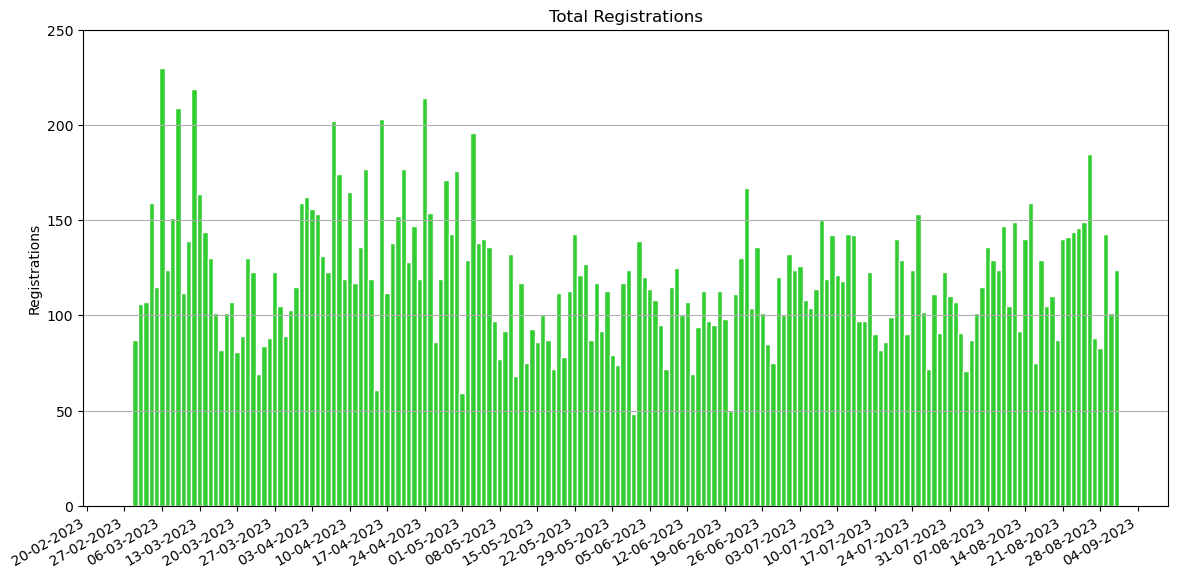

In [425]:
df = merged_df.groupby(['date'],as_index=False).registrations.sum()
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.bar(df['date'], df['registrations'], width=1, color='limegreen', edgecolor='white')

ax.set(ylabel='Registrations', title='Total Registrations', ylim=(0, 250))

ax.grid(axis='y')
plt.savefig(f'./charts/Total_registrations.png')
plt.show()

**Итоговые регистрации с разбивкой по платформам**

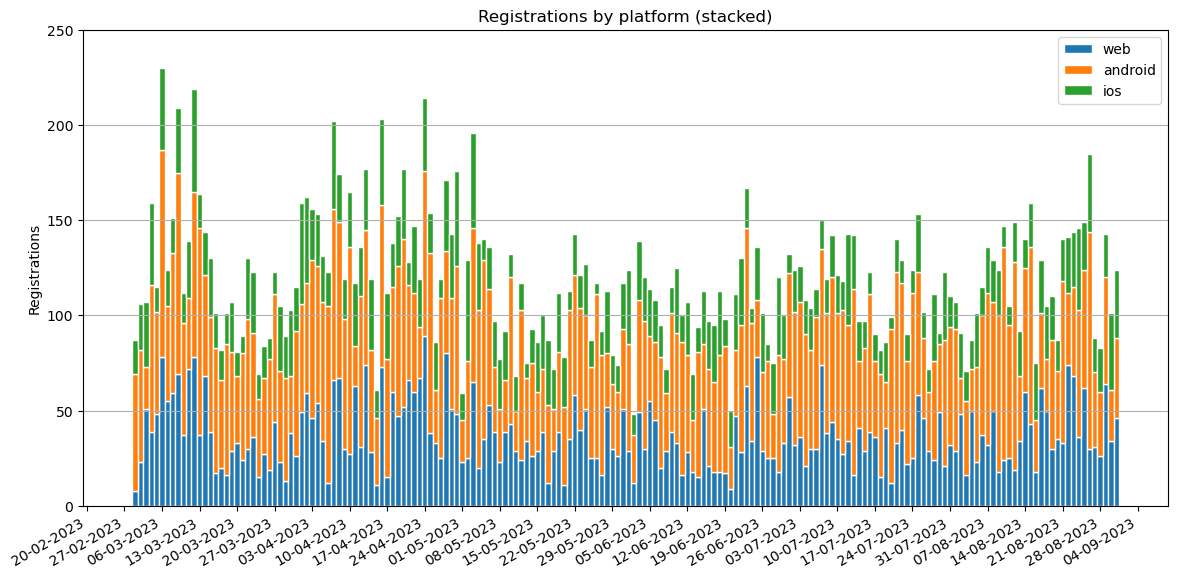

In [427]:
# Преобразуем данные в сводную таблицу, в которой названия платформ будут расположены в колонках, а даты — в строках.
df = merged_df \
    .groupby(['date', 'platform'], as_index=False) \
    .agg({'registrations': 'sum'}) \
    .rename(columns={'registrations': 'registrations_count'}) \
    .pivot(index='date', columns='platform', values='registrations_count') \
    .fillna(0).astype('int') \
    .sort_index(ascending=True)

fig, ax = plt.subplots()
fig.set_size_inches(14, 7)


ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.bar(df.index, df["web"], label = "web", width = 1,
      edgecolor='white') 
ax.bar(df.index, df["android"], label = "android", bottom = df.web, width = 1,
      edgecolor='white')
ax.bar(df.index, df["ios"], bottom = df.android + df.web, label = "ios", width = 1,
      edgecolor='white') 

ax.set(ylabel='Registrations', title='Registrations by platform (stacked)', ylim=(0, 250))

ax.legend(labels = ["web", "android", "ios"])

ax.grid(axis='y')
plt.savefig(f'./charts/Registrations_by_platform.png')
plt.show()

**Конверсии по каждой платформе**

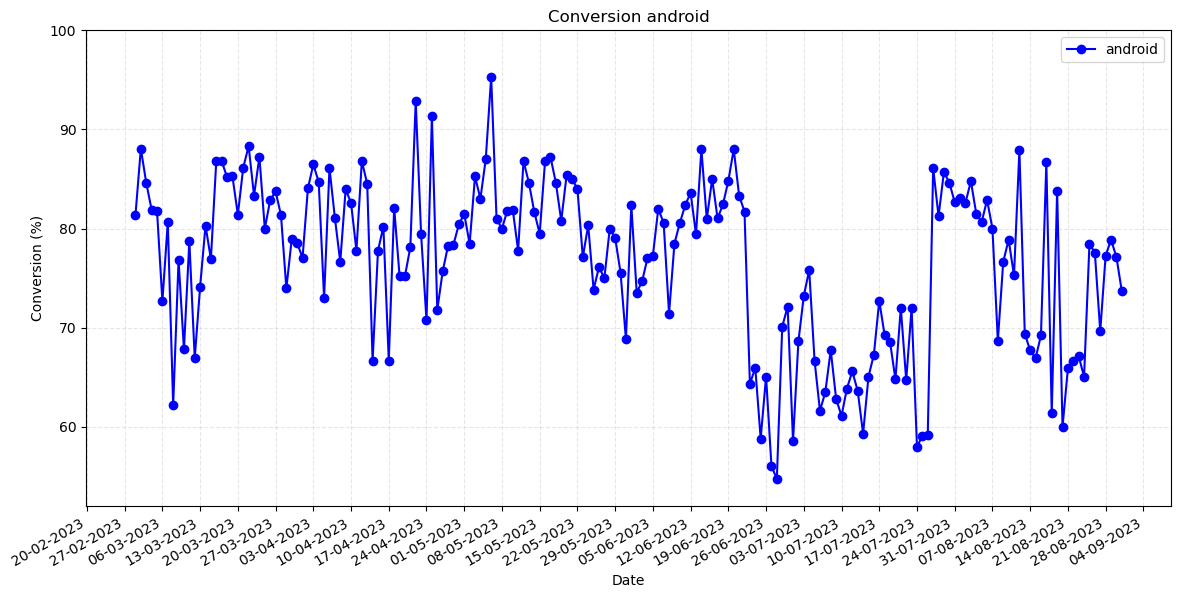

In [429]:
# Конверсия по android
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_android = merged_df[merged_df['platform'] == 'android']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values_android,
        # 'bo-' means blue color, round points, solid lines
        'bo-')
ax.grid(True, linestyle='--', alpha=0.3)

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion android', ylim=(52, 100))
ax.legend(["android"])
plt.savefig(f'./charts/Conversion_android.png')
plt.show()


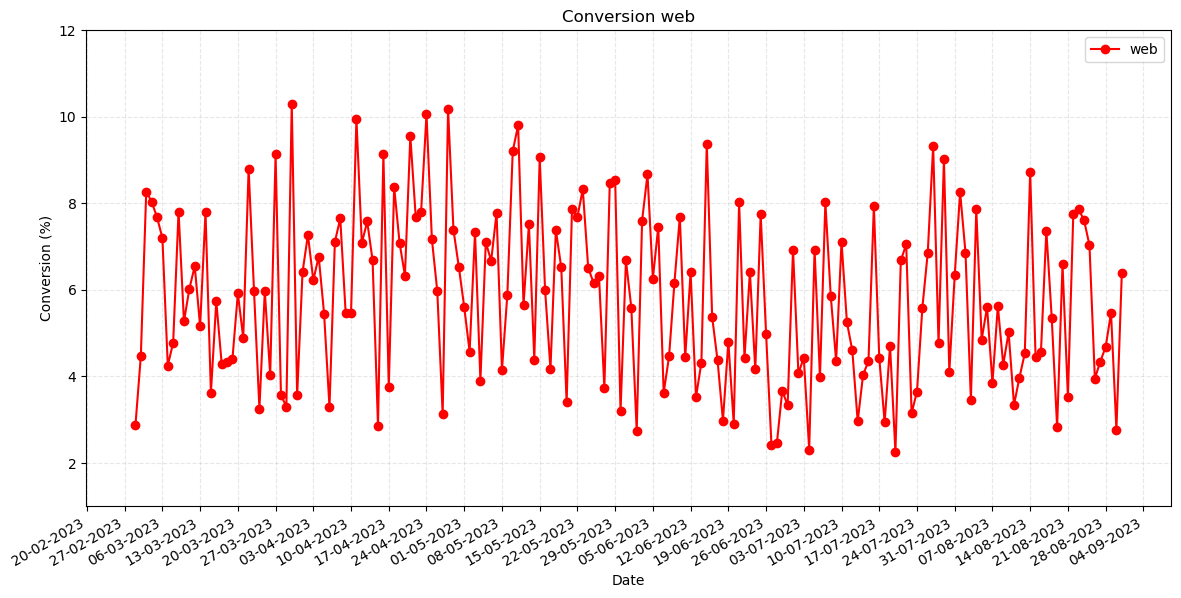

In [431]:
# Конверсия по web
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_web = merged_df[merged_df['platform'] == 'web']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values_web,
        'ro-')
ax.grid(True, linestyle='--', alpha=0.3)

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion web', ylim=(1, 12))
ax.legend(["web"])
plt.savefig(f'./charts/Conversion_web.png')
plt.show()


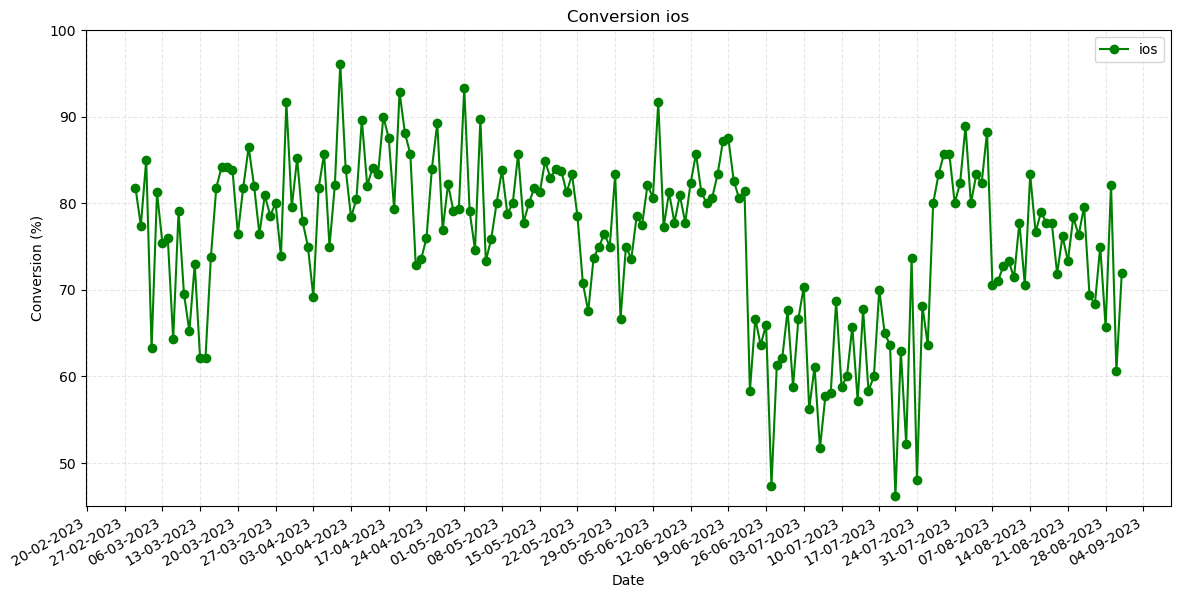

In [433]:
# Конверсия по ios
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_ios = merged_df[merged_df['platform'] == 'ios']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()


ax.plot(labels,
        values_ios,
        'go-')
ax.grid(True, linestyle='--', alpha=0.3)

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion ios', ylim=(45, 100))
ax.legend(["ios"])
plt.savefig(f'./charts/Conversion_ios.png')
plt.show()


Итоговые конверсии

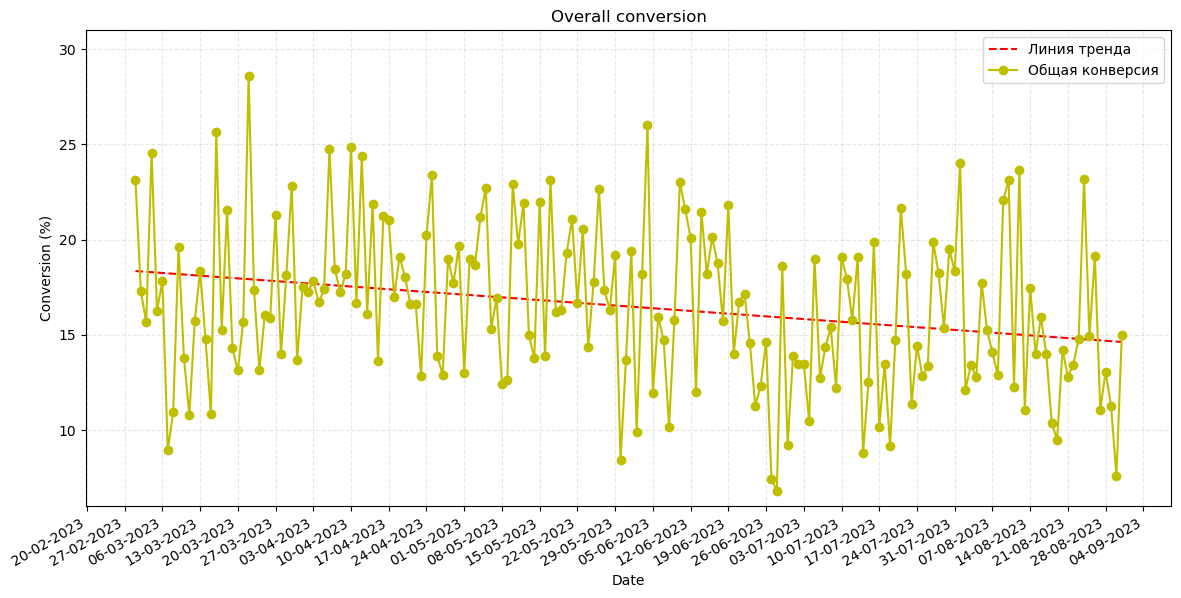

In [435]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
data = result.assign(conversion=lambda x: round(x.registrations*100/x.visits,2))

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

labels = matplotlib.dates.date2num(data['date'])
values = data['conversion']
z = np.polyfit(labels, data['conversion'], 1)
p = np.poly1d(z)
# Рисуем линию тренда
ax.plot(labels, p(labels), "r--")

ax.plot(labels,
        values,
        'yo-')
ax.grid(True, linestyle='--', alpha=0.3)

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Overall conversion', ylim=(6, 31))
ax.legend(['Линия тренда', 'Общая конверсия'])
plt.savefig(f'./charts/Overall_conversion.png')
plt.show()

**Стоимости реклам**

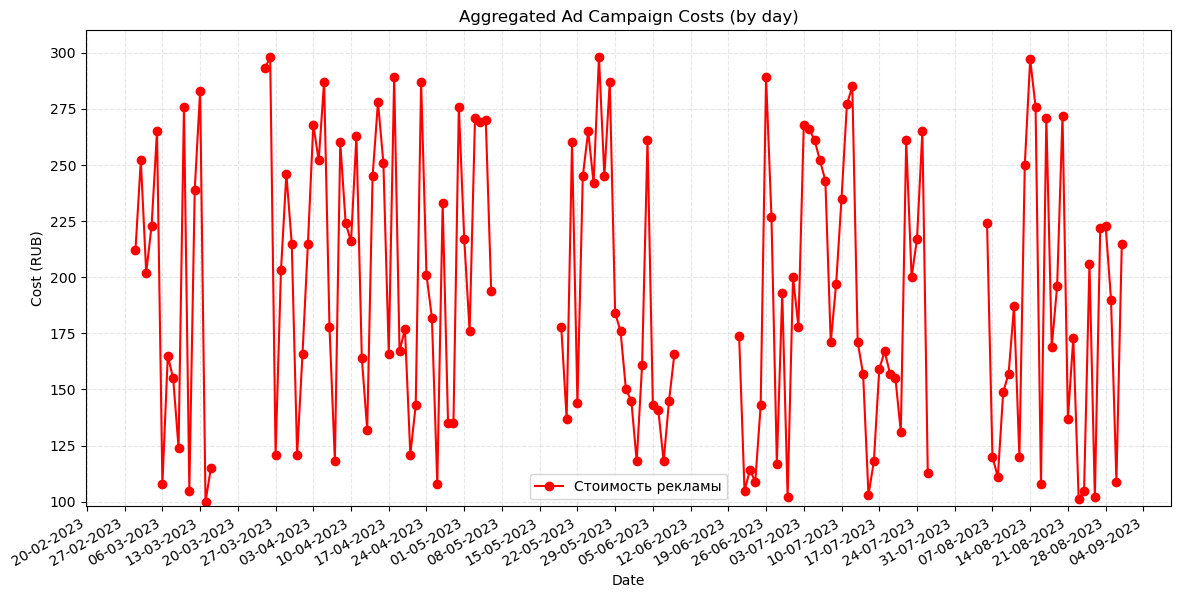

In [437]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values = result['cost']
labels = result['date']
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values,
        'ro-')
ax.grid(True, linestyle='--', alpha=0.3)

ax.set(ylabel='Cost (RUB)', xlabel='Date', title='Aggregated Ad Campaign Costs (by day)', ylim=(98, 310))
ax.legend(["Стоимость рекламы"])
plt.savefig(f'./charts/Aggr_ad_cost.png')
plt.show()

Визиты и регистрации с выделением рекламных кампаний

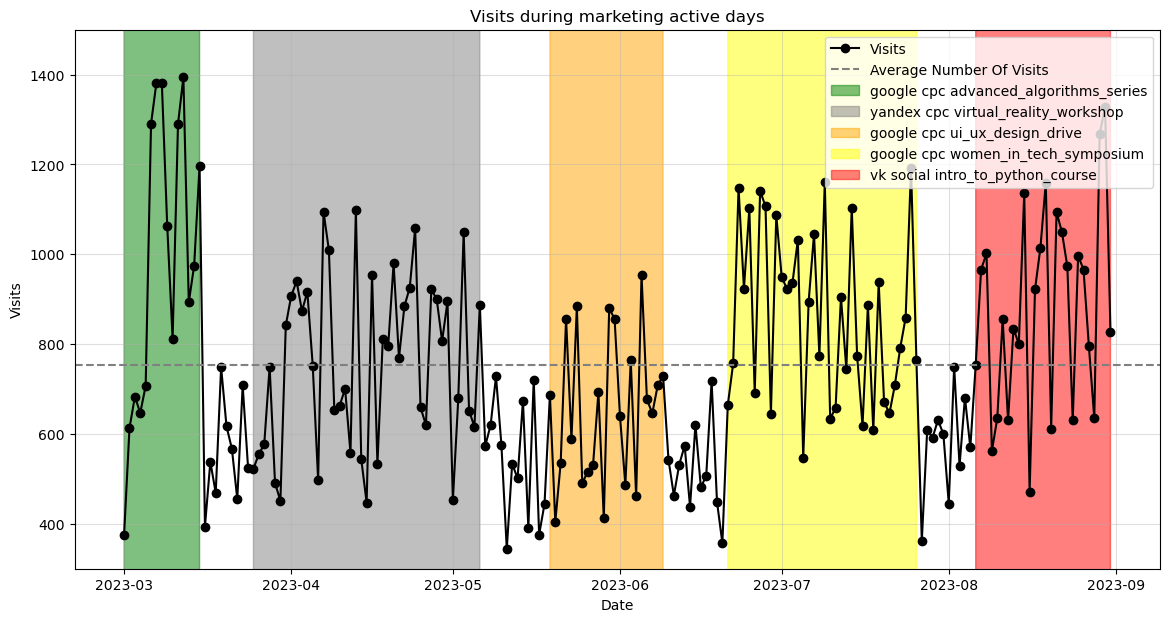

In [439]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])
# Список всех рекламных кампаний
ads_names = list(data['ad'].unique())
# Датафрейм с датами начала и окончания рекламных кампаний
ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

values = data['visits']
labels = data['date']

ax.plot(labels, values, 'ko-')
ax.grid(True, linestyle='-', alpha=0.4)
ax.set(ylabel='Visits', xlabel='Date', title='Visits during marketing active days', ylim=(300,1500))

# Рисуем линию среднего
plt.axhline(y=values.mean(), color='grey', linestyle='--')

# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.legend(['Visits',
           'Average Number Of Visits', 
           'google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.savefig(f'./charts/Visits_marketing.png')
plt.show()

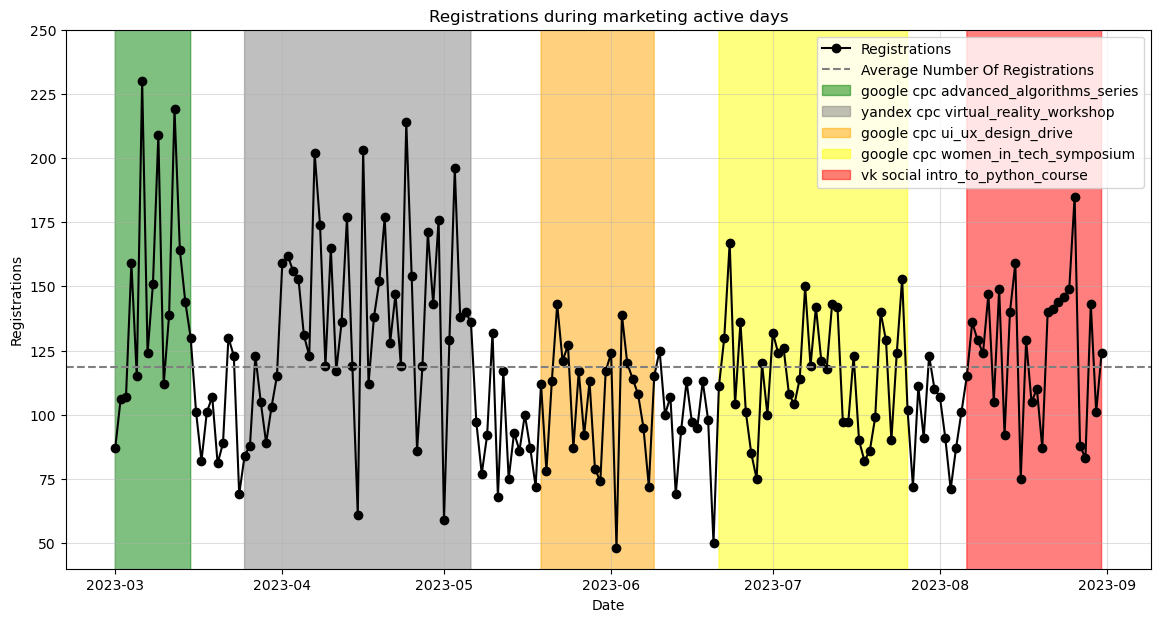

In [441]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])

ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

values = data['registrations']
labels = data['date']

ax.plot(labels, values, 'ko-')
ax.grid(True, linestyle='-', alpha=0.4)

ax.set(ylabel='Registrations', xlabel='Date', title='Registrations during marketing active days', ylim=(40,250))

# Рисуем линию среднего
plt.axhline(y=values.mean(), color='grey', linestyle='--')

# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.legend(['Registrations',
           'Average Number Of Registrations', 
           'google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.savefig(f'./charts/Registrations_marketing.png')
plt.show()

Итоговые визиты с разбивкой по платформам + реклама

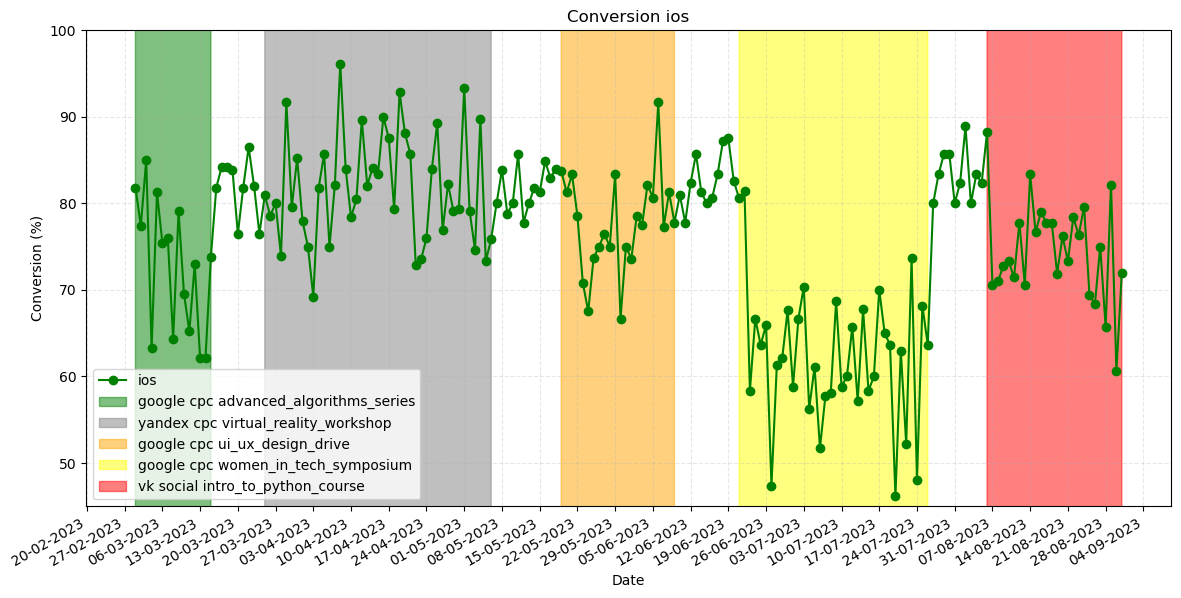

In [443]:
# Конверсия по ios и реклама
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_ios = merged_df[merged_df['platform'] == 'ios']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']

data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])
ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()


ax.plot(labels,
        values_ios,
        'go-')
ax.grid(True, linestyle='--', alpha=0.3)


# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion ios', ylim=(45, 100))

ax.legend(labels = ['ios','google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.savefig(f'./charts/Conversion_ios_with_ads.png')
plt.show()

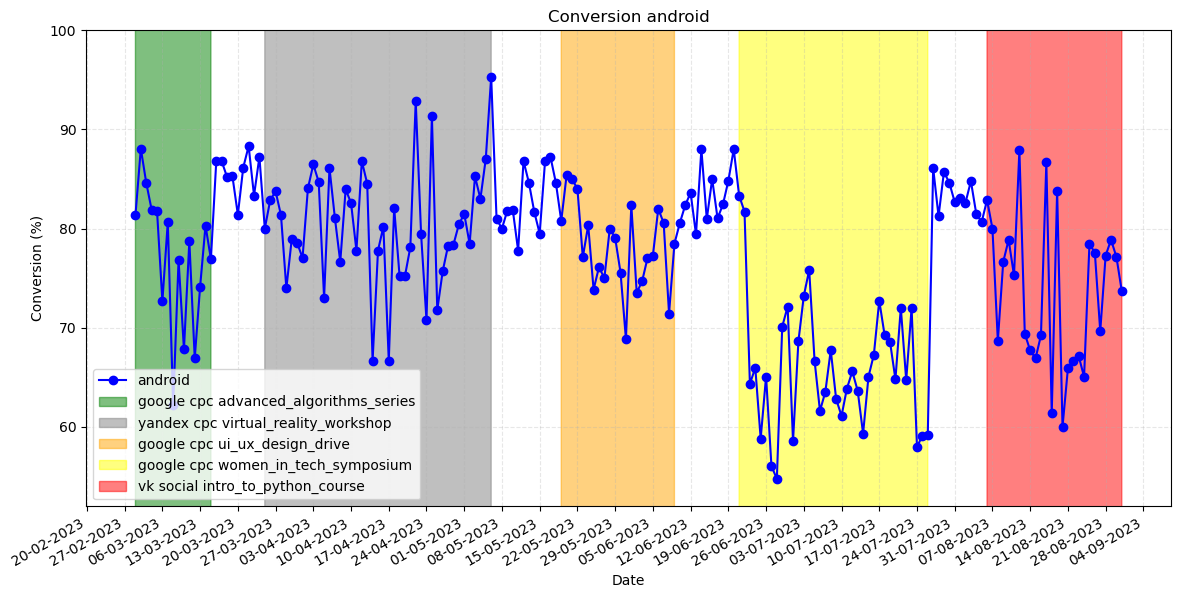

In [445]:
# Конверсия по android + реклама
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_and = merged_df[merged_df['platform'] == 'android']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']

data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])
ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values_and,
        # 'bo-' means blue color, round points, solid lines
        'bo-')
ax.grid(True, linestyle='--', alpha=0.3)

# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion android', ylim=(52, 100))
ax.legend(["android",'google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.savefig(f'./charts/Conversion_android_with_ads.png')
plt.show()

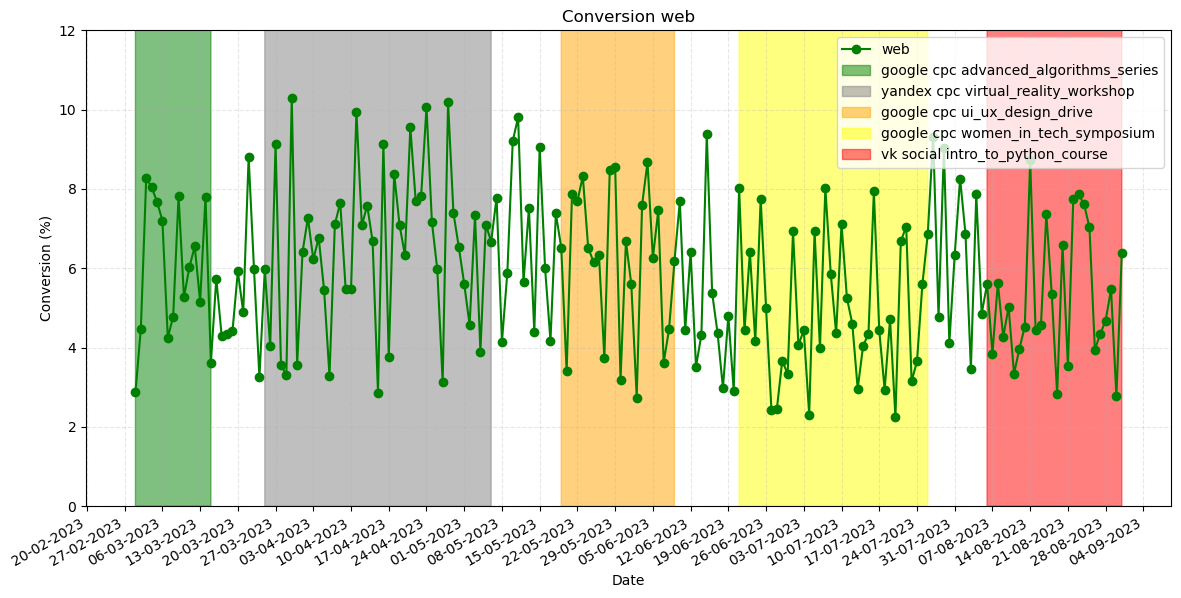

In [447]:
# Конверсия по web и реклама
fig, ax = plt.subplots()
fig.set_size_inches(14, 7)
values_ios = merged_df[merged_df['platform'] == 'web']['conversion']
labels = merged_df[merged_df['platform'] == 'android']['date']

data = result.assign(ad=lambda x: x['utm_source'] + ' ' + x['utm_medium'] + ' ' + x['utm_campaign'])
ads_dates = data.groupby(['ad'], as_index=False).date.agg(['min', 'max'])

ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=MO, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

ax.plot(labels,
        values_ios,
        'go-')
ax.grid(True, linestyle='--', alpha=0.3)

# Обозначаем периоды проведения рекламных кампаний
plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['min'],
                      ads_dates[ads_dates['ad']=='google cpc advanced_algorithms_series']['max'],
                      alpha = 0.5, color = 'green')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['min'],
                      ads_dates[ads_dates['ad']=='yandex cpc virtual_reality_workshop']['max'],
                      alpha = 0.5, color = 'grey')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['min'],
                      ads_dates[ads_dates['ad']=='google cpc ui_ux_design_drive']['max'],
                      alpha = 0.5, color = 'orange')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['min'],
                      ads_dates[ads_dates['ad']=='google cpc women_in_tech_symposium']['max'],
                      alpha = 0.5, color = 'yellow')

plt.fill_betweenx(np.arange(0, 1500, 1),
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['min'],
                      ads_dates[ads_dates['ad']=='vk social intro_to_python_course']['max'],
                      alpha = 0.5, color = 'red')

ax.set(ylabel='Conversion (%)', xlabel='Date', title='Conversion web', ylim=(0, 12))

ax.legend(labels = ['web','google cpc advanced_algorithms_series',
           'yandex cpc virtual_reality_workshop',
           'google cpc ui_ux_design_drive',
           'google cpc women_in_tech_symposium',
           'vk social intro_to_python_course'])
plt.savefig(f'./charts/Conversion_web_with_ads.png')
plt.show()